Определение наличия экрана ПК

# Загрузка библиотек

In [14]:
import os
import shutil
import hashlib
import imagehash
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
from pathlib import Path
from collections import Counter
from matplotlib import pyplot as plt

In [11]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Формирование выборки и фильтрация дубликатов

In [5]:
path_photos = Path('receipt_screen_data')

In [7]:
filenames = []
for folder in tqdm(os.listdir(path_photos)):
    folderfiles = [(path_photos / folder / x).__str__() for x in os.listdir(path_photos / folder)]
    filenames.extend(folderfiles)

100%|██████████| 10/10 [00:00<00:00, 138.96it/s]


In [12]:
hash_size = 8
def phash(image: Image.Image, hash_size: int) -> str:
    return str(
        hashlib.sha256(
            bytearray(
                imagehash.phash(
                    image, hash_size=hash_size
                ).hash.flatten().astype(int).tolist())
            ).hexdigest())

In [13]:
hashes = []
for file in tqdm(filenames):
    file_hash = phash(Image.open(file), hash_size)
    hashes.append(file_hash)

100%|██████████| 15581/15581 [02:57<00:00, 87.85it/s] 


In [15]:
df = pd.DataFrame(
    {
        'filename': filenames,
        'phash': hashes
    }
)
df.head()

,filename,phash
0,receipt_screen_data\new_terminals\IM0204731777...,1e91796aba66e42c6eafab5f50950136ae7354c3b28e75...
1,receipt_screen_data\new_terminals\IM0204764217...,cb3df177622386f59ec19815ab3b53718098bbeaf70f77...
2,receipt_screen_data\new_terminals\IM0204877219...,ba6e38519086876cdcb5cb0ad1083571e4f86d493ccd55...
3,receipt_screen_data\new_terminals\IM0204884147...,99e3cc9730e0455aa6ada16f757a67050bb562b650b386...
4,receipt_screen_data\new_terminals\TS904426580-...,99fe828863800f8ac43067094dc53880b513a8edb82cbf...


In [16]:
counter = Counter(df['phash'])
df_hashes = pd.DataFrame(
    {
        'phash': list(counter.keys()),
        'count': list(counter.values())
    }
)
n_dupl = df_hashes[df_hashes['count']>1]['count'].sum()
print(f'Количество фото с дубликатами: {n_dupl}')

Количество фото с дубликатами: 3722


In [20]:
df_temp_duplicate = df_hashes[
    df_hashes['count']>1
].iloc[:3]
duplicated_images = df.loc[
    df['phash'].isin(df_temp_duplicate['phash'])
]['filename'].values

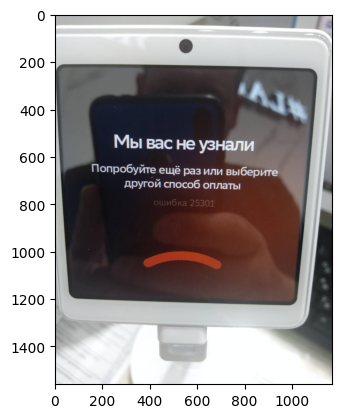

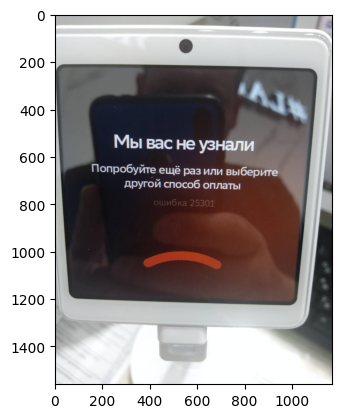

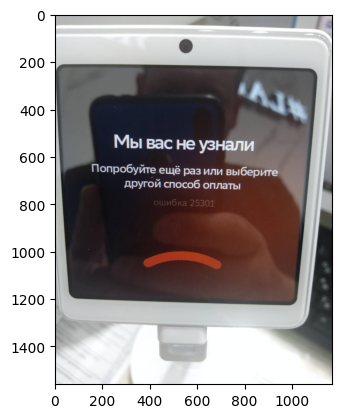

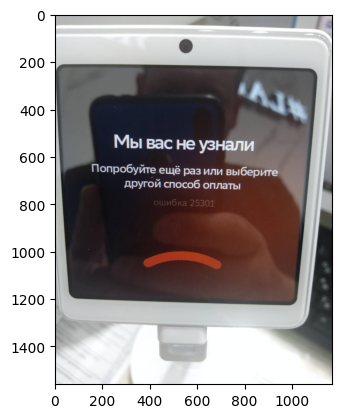

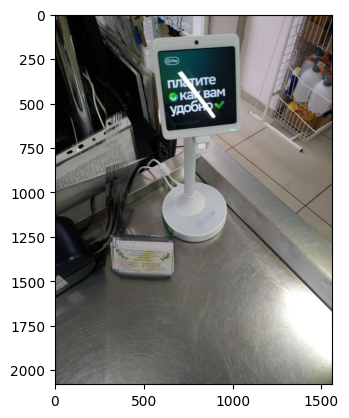

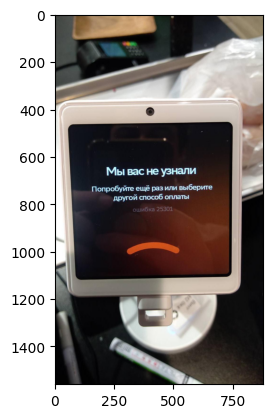

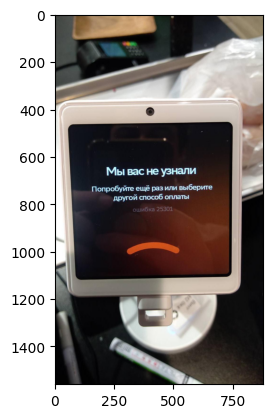

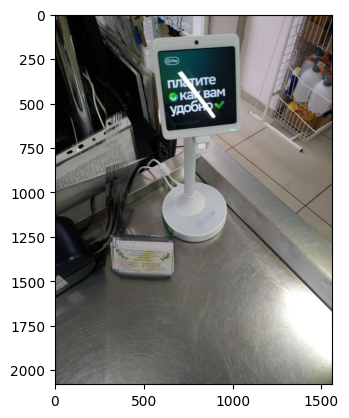

In [21]:
# duplicate photos examples
for image in duplicated_images:
    im = Image.open(image)
    plt.imshow(im)
    plt.show()

In [ ]:
df['target'] = 0
df.loc[
    df['filename'].apply(lambda x: 'pc_screen' in x.split('\\')[-2]),
    'target'
] = 1

In [22]:
df.drop_duplicates(subset=['phash'], inplace=True)
df.reset_index(inplace=True, drop=True)
df.to_pickle('df_markup_nodupl_pcscreen.pkl')

# EDA

In [32]:
df['target'].value_counts()

target
0    7688
1    5459
Name: count, dtype: int64

In [35]:
df.loc[
    df['filename'].apply(lambda x: 'augm' not in x),
    'target'
].value_counts()

target
0    7688
1    1286
Name: count, dtype: int64